In [1]:
from transformers import pipeline

/opt/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [116]:
# Загрузка NER-модел
# ner_pipeline = pipeline(
#     "ner", 
#     model="DeepPavlov/rubert-base-cased", 
#     tokenizer="DeepPavlov/rubert-base-cased", 
#     aggregation_strategy="simple"
# )

# Загрузка NER-модели
ner_pipeline = pipeline(
    "ner", 
    model="zaalbar/rubert-finetuned-ner", 
    tokenizer="zaalbar/rubert-finetuned-ner"
)

# Текст
text = """
В городе Новомирске проходила ежегодная конференция "Технологии будущего", организованная компанией "ИнноваТех". 
На мероприятии выступили известные спикеры: Иван Петров, генеральный директор "ИнноваТех", и Мария Сидорова, 
ведущий аналитик компании "ГлобалДатаТех". Они представили новую технологию обработки данных, которая уже используется 
в проектах с участием университета МГУ и исследовательского центра "Альфа-Лаб". 

После конференции Иван Петров встретился с главой городской администрации Новомирска, Алексеем Кузнецовым, чтобы обсудить 
возможности сотрудничества в рамках городского проекта "Умный город". Алексей Кузнецов предложил внедрить разработки 
"ИнноваТех" в систему управления транспортом и энергоснабжением города. 

Мария Сидорова, в свою очередь, отправилась в кафе "Старый город", где встретила своего давнего друга Дмитрия Волкова, 
специалиста по кибербезопасности из компании "СекьюритиГрупп". Они обсудили возможность совместной работы над проектом 
по защите данных для банка "ФинансБезопасность". 

В конце дня Иван Петров и Мария Сидорова провели совещание с командой "ИнноваТех", чтобы обсудить планы на следующий год. 
Они решили сосредоточиться на развитии партнёрских отношений с университетом МГУ и расширении сотрудничества с зарубежными 
компаниями, такими как "ГлобалДатаТех".
"""

# Применение пайплайн к рассказу
ner_results = ner_pipeline(text)

# Вывод сущностей
print("Найденные именованные сущности:")
for entity in ner_results:
    print(entity)

Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Найденные именованные сущности:
{'entity': 'B-LOC', 'score': 0.957809, 'index': 3, 'word': 'Новом', 'start': 10, 'end': 15}
{'entity': 'I-LOC', 'score': 0.94164354, 'index': 4, 'word': '##ир', 'start': 15, 'end': 17}
{'entity': 'I-LOC', 'score': 0.9776512, 'index': 5, 'word': '##ске', 'start': 17, 'end': 20}
{'entity': 'B-PER', 'score': 0.9838216, 'index': 30, 'word': 'Иван', 'start': 159, 'end': 163}
{'entity': 'I-PER', 'score': 0.9810347, 'index': 31, 'word': 'Петров', 'start': 164, 'end': 170}
{'entity': 'B-PER', 'score': 0.98390156, 'index': 43, 'word': 'Мария', 'start': 208, 'end': 213}
{'entity': 'I-PER', 'score': 0.98003834, 'index': 44, 'word': 'Сидорова', 'start': 214, 'end': 222}
{'entity': 'B-ORG', 'score': 0.98461443, 'index': 72, 'word': 'университета', 'start': 367, 'end': 379}
{'entity': 'I-ORG', 'score': 0.9872859, 'index': 73, 'word': 'МГУ', 'start': 380, 'end': 383}
{'entity': 'B-PER', 'score': 0.95729864, 'index': 85, 'word': 'Иван', 'start': 445, 'end': 449}
{'entit

In [120]:
from collections import Counter

# Избавление от неправельного деления слов
def merge_subwords(entities):
    merged_entities = []
    current_entity = None
    
    for entity in entities:
        word = entity['word']
        
        # Если слово начинается с "##", добавляем его к текущей сущности
        if word.startswith("##"):
            if current_entity is not None:
                current_entity += word[2:]  # Убираем "##"
            else:
                # Если "##" встречается без предыдущего слова, игнорируем его
                continue
        else:
            # Если новое слово, сохраняем предыдущую сущность
            if current_entity is not None:
                merged_entities.append(current_entity)
            current_entity = word
    
    # Добавление последней сущности
    if current_entity is not None:
        merged_entities.append(current_entity)
    
    return merged_entities



# Подсчёт частот
entity_counts = Counter(merged_entities)

# Пример использования
merged_entities = merge_subwords(ner_results)

# Вывод результатов
print("Частота сущностей:")
for entity, count in entity_counts.items():
    print(f"{entity}: {count}")

Частота сущностей:
Новомирске: 1
Иван: 3
Петров: 3
Мария: 3
Сидорова: 3
университета: 1
МГУ: 2
Новомирска: 1
Алексеем: 1
Кузнецовым: 1
Алексей: 1
Кузнецов: 1
Дмитрия: 1
Волкова: 1
университетом: 1


In [122]:
import re

# Разбивание текста на предложения
sentences = re.split(r'[.!?]', text)
sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

# Создание списока пар сущностей для каждого предложения
sentence_entity_pairs = []

for sentence in sentences:
    # Извлечение сущности для текущего предложения
    sentence_entities = [entity['word'] for entity in ner_pipeline(sentence)]
    
    # Формирование пар сущностей
    pairs = [(sentence_entities[i], sentence_entities[j]) 
             for i in range(len(sentence_entities)) 
             for j in range(i + 1, len(sentence_entities))]
    
    # Добавление пары в общий список
    sentence_entity_pairs.append((sentence, pairs))

# Результат
for sentence, pairs in sentence_entity_pairs:
    print(f"Предложение: {sentence}")
    print(f"Пары сущностей: {pairs}\n")

Предложение: В городе Новомирске проходила ежегодная конференция "Технологии будущего", организованная компанией "ИнноваТех"
Пары сущностей: [('Новом', '##ир'), ('Новом', '##ске'), ('##ир', '##ске')]

Предложение: На мероприятии выступили известные спикеры: Иван Петров, генеральный директор "ИнноваТех", и Мария Сидорова, 
ведущий аналитик компании "ГлобалДатаТех"
Пары сущностей: [('Иван', 'Петров'), ('Иван', 'Мария'), ('Иван', 'Сидорова'), ('Петров', 'Мария'), ('Петров', 'Сидорова'), ('Мария', 'Сидорова')]

Предложение: Они представили новую технологию обработки данных, которая уже используется 
в проектах с участием университета МГУ и исследовательского центра "Альфа-Лаб"
Пары сущностей: [('университета', 'МГУ')]

Предложение: После конференции Иван Петров встретился с главой городской администрации Новомирска, Алексеем Кузнецовым, чтобы обсудить 
возможности сотрудничества в рамках городского проекта "Умный город"
Пары сущностей: [('Иван', 'Петров'), ('Иван', 'Новом'), ('Иван', '##ир

In [124]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Загрузка токенизатора и модели
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased")

# Пример функции для извлечения отношений
def extract_relation(sentence, entity1, entity2):
    # Добавление маркеров
    marked_sentence = sentence.replace(entity1, f"[E1]{entity1}[/E1]").replace(entity2, f"[E2]{entity2}[/E2]")
    
    # Токенизация текста
    inputs = tokenizer(marked_sentence, return_tensors="pt", truncation=True, padding=True)
    
    # Получение предсказания
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    
    return predicted_class

# Пример использования
for sentence, pairs in sentence_entity_pairs:
    for entity1, entity2 in pairs:
        relation = extract_relation(sentence, entity1, entity2)
        print(f"Отношение между '{entity1}' и '{entity2}': {relation}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Отношение между 'Новом' и '##ир': 1
Отношение между 'Новом' и '##ске': 1
Отношение между '##ир' и '##ске': 1
Отношение между 'Иван' и 'Петров': 1
Отношение между 'Иван' и 'Мария': 1
Отношение между 'Иван' и 'Сидорова': 1
Отношение между 'Петров' и 'Мария': 1
Отношение между 'Петров' и 'Сидорова': 1
Отношение между 'Мария' и 'Сидорова': 1
Отношение между 'университета' и 'МГУ': 1
Отношение между 'Иван' и 'Петров': 1
Отношение между 'Иван' и 'Новом': 1
Отношение между 'Иван' и '##ир': 1
Отношение между 'Иван' и '##ска': 1
Отношение между 'Иван' и 'Алексеем': 1
Отношение между 'Иван' и 'Кузнецов': 1
Отношение между 'Иван' и '##ым': 1
Отношение между 'Петров' и 'Новом': 1
Отношение между 'Петров' и '##ир': 1
Отношение между 'Петров' и '##ска': 1
Отношение между 'Петров' и 'Алексеем': 1
Отношение между 'Петров' и 'Кузнецов': 1
Отношение между 'Петров' и '##ым': 1
Отношение между 'Новом' и '##ир': 1
Отношение между 'Новом' и '##ска': 1
Отношение между 'Новом' и 'Алексеем': 1
Отношение между 

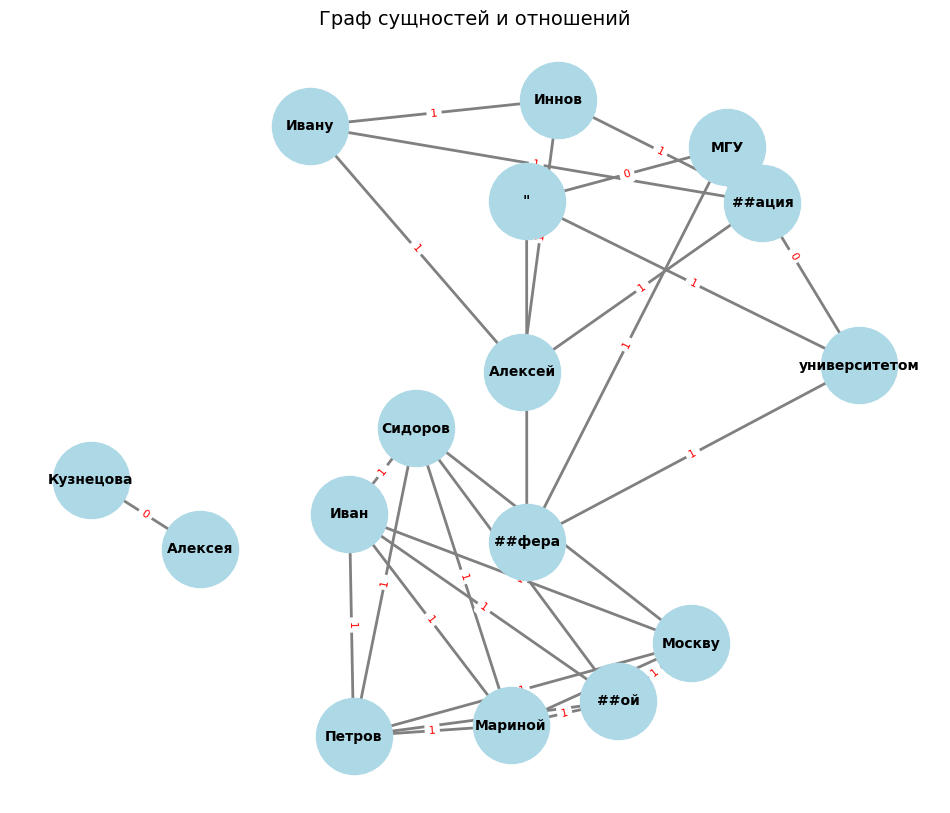

In [128]:
import networkx as nx
import matplotlib.pyplot as plt

# Создание графа и добавление размера графика и расстояние между узлами
plt.figure(figsize=(12, 10))  # Увеличение 
pos = nx.spring_layout(G, k=1.5)

# Узлы
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=3000)

# Рёбра
nx.draw_networkx_edges(G, pos, edge_color="gray", width=2)

# Метки узлов
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Метки рёбер
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(
    G, pos, 
    edge_labels=edge_labels, 
    font_size=8, 
    font_color="red"
)

plt.title("Граф сущностей и отношений", fontsize=14)
plt.axis("off")
plt.show()